In [1]:
import json
import csv
from pprint import pprint
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

In [2]:
path = '/Users/stylshreyeshi/Desktop/location.json'
with open(path) as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame.from_dict(data, orient='columns')
df.head()

,locations
0,"{'timestampMs': '1543320317919', 'latitudeE7':..."
1,"{'timestampMs': '1543319700075', 'latitudeE7':..."
2,"{'timestampMs': '1543319641689', 'latitudeE7':..."
3,"{'timestampMs': '1543319100119', 'latitudeE7':..."
4,"{'timestampMs': '1543318465263', 'latitudeE7':..."


In [4]:
df = pd.read_json((df['locations']).to_json(), orient='index')
df.head()

,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy
0,24,NaN,NaN,NaN,284199428,770382287,2018-11-27 12:05:17.919,NaN,NaN
1,24,NaN,NaN,NaN,284199504,770382172,2018-11-27 11:55:00.075,NaN,NaN
2,23,NaN,NaN,NaN,284199471,770381858,2018-11-27 11:54:01.689,NaN,NaN
3,22,"[{'timestampMs': '1543318824627', 'activity': ...",NaN,NaN,284199504,770382163,2018-11-27 11:45:00.119,NaN,NaN
4,24,NaN,NaN,NaN,284199119,770381655,2018-11-27 11:34:25.263,NaN,NaN


In [5]:
df['activity'].fillna(value='-',inplace=True)
df['activity'] = df['activity'].apply(lambda x: "".join(map(str,x)) )

In [6]:
df['activity_timestampMs'] = df['activity'].apply(lambda x: x[x.find('timestampMs')+15:30])
df['activity_data'] = df['activity'].apply(lambda x: x[x.find('activity')+22:x.find('confidence')-4])
df['confidence'] = df['activity'].apply(lambda x: x[x.find('confidence')+13:x.find('}')])
df.head()

,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,activity_timestampMs,activity_data,confidence
0,24,-,NaN,NaN,284199428,770382287,2018-11-27 12:05:17.919,NaN,NaN,,,
1,24,-,NaN,NaN,284199504,770382172,2018-11-27 11:55:00.075,NaN,NaN,,,
2,23,-,NaN,NaN,284199471,770381858,2018-11-27 11:54:01.689,NaN,NaN,,,
3,22,"{'timestampMs': '1543318824627', 'activity': [...",NaN,NaN,284199504,770382163,2018-11-27 11:45:00.119,NaN,NaN,1543318824627,STILL,52
4,24,-,NaN,NaN,284199119,770381655,2018-11-27 11:34:25.263,NaN,NaN,,,


In [7]:
from datetime import datetime
df['activity_timestampMs'] = np.where(df['activity_timestampMs']=='',0,pd.to_numeric(df['activity_timestampMs']))
df['activity_timestampMs'] = df['activity_timestampMs'].apply(lambda x: datetime.utcfromtimestamp(int(x/1000)).strftime('%Y-%m-%d %H:%M:%S'))

In [9]:
df['latitudeE7'] = df['latitudeE7'].apply(lambda x: int(x)/10000000)
df['longitudeE7'] = df['longitudeE7'].apply(lambda x: int(x)/10000000)

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, polygon
%matplotlib inline
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitudeE7, df.latitudeE7))
gdf.head()

,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,activity_timestampMs,activity_data,confidence,geometry
0,24,-,NaN,NaN,28.419943,77.038229,2018-11-27 12:05:17.919,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.0382287 28.4199428)
1,24,-,NaN,NaN,28.419950,77.038217,2018-11-27 11:55:00.075,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.03821720000001 28.4199504)
2,23,-,NaN,NaN,28.419947,77.038186,2018-11-27 11:54:01.689,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.03818579999999 28.4199471)
3,22,"{'timestampMs': '1543318824627', 'activity': [...",NaN,NaN,28.419950,77.038216,2018-11-27 11:45:00.119,NaN,NaN,2018-11-27 11:40:24,STILL,52,POINT (77.0382163 28.4199504)
4,24,-,NaN,NaN,28.419912,77.038166,2018-11-27 11:34:25.263,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.03816550000001 28.4199119)


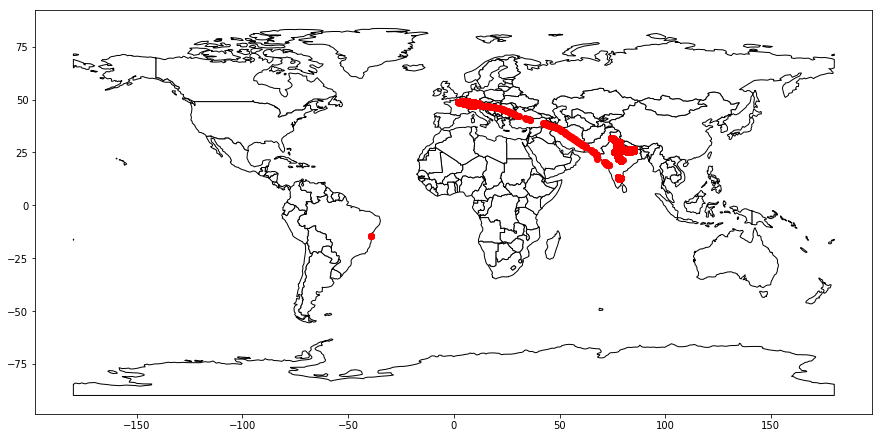

In [12]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
gdf.plot(ax=ax, color='red')
plt.show()

In [13]:
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [42]:
m = folium.Map([28.48, 77.07], zoom_start=12)
df1 = df[(df['timestampMs'].dt.year==2018) & (df['timestampMs'].dt.month==4) & (df['timestampMs'].dt.day<6)]
for index, row in df1.iterrows():
    folium.CircleMarker([row['latitudeE7'], row['longitudeE7']],
                        radius=0.0001,
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)
point_ = df1[['latitudeE7', 'longitudeE7']].as_matrix()
m.add_child(plugins.HeatMap(point_, radius=15))
m

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [15]:
df.head()

,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,activity_timestampMs,activity_data,confidence,geometry
0,24,-,NaN,NaN,28.419943,77.038229,2018-11-27 12:05:17.919,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.0382287 28.4199428)
1,24,-,NaN,NaN,28.419950,77.038217,2018-11-27 11:55:00.075,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.03821720000001 28.4199504)
2,23,-,NaN,NaN,28.419947,77.038186,2018-11-27 11:54:01.689,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.03818579999999 28.4199471)
3,22,"{'timestampMs': '1543318824627', 'activity': [...",NaN,NaN,28.419950,77.038216,2018-11-27 11:45:00.119,NaN,NaN,2018-11-27 11:40:24,STILL,52,POINT (77.0382163 28.4199504)
4,24,-,NaN,NaN,28.419912,77.038166,2018-11-27 11:34:25.263,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.03816550000001 28.4199119)


In [68]:
import reverse_geocoder as rg 

def reverseGeocode(coordinates): 
    result = ((rg.search(coordinates))[0])['name'] 
    z = result[0]
    return (z['name'])

In [36]:
df2 = df.copy()

In [67]:
#Working on df copy df2
df2['coordinates'] = list(zip(df2.latitudeE7, df2.longitudeE7))

In [72]:
df2 = df2.sa
df2['City'] = df2['coordinates'].apply(lambda x: ((rg.search(coordinates))[0])['name'])

KeyboardInterrupt: 